[View in Colaboratory](https://colab.research.google.com/github/danielcanueto/misc/blob/master/Copy_of_Copy_of_Fastai_lesson2.ipynb)

# **Automatic filtering of image datasets by crossvalidated prediction in training datasets**

In numeric tabular data, it is common to try filter suboptimal rows which give more noise than signal to the dataset through EDA methods such as dimensionality reduction and outlier analysis. These methods can be relatively automated.

In CNN models, it is much more difficult to perform this method as it is much more difficult to analyze the features which might discriminate labels. Consequently, it si much more difficult to automate EDA. In the case of images, a lot of time might be spent analyzing images and applying right labels. The need of large datasets to take advantage of deep learning approaches exacerbates this bottleneck in applied deep learning (e.g., image classification).

In order to automate the filtering of mislabelled (or non representative of the most important features associated with the label) images, I propose reframing the problem this way:

- The benefits of increasing the dataset follow a saturation curve trend. For example, a dataset of 500 images can help achieve 0.85 accuracy, and a dataset of 1000 images achieves a 0.88 accuracy. It is expected that the reduction of a dataset in half only means small decreases in accuracy.

- The labels of the images of the training dataset should be correctly predicted if they are  correctly labelled.

- These labels should be correctly predicted even using a reduced version of the training dataset to predict its label.

For example, if we generate 10 random 50%-50% splits of a training dataset and we try to predict the label of a 50% split using the other 50% split, we should have an average of 5 label predictions for each image of the training dataset. With this information, we should already be able to observe images consistently mislabelled which might indicate possibles images to remove from the training dataset.

To check this hypothesis, I will follow the example of the fastai lesson1 of the classification in dogs and cats by transfer learning of the resnet34 model.

In [0]:
#This kills all VMs. Only helpful to work if memory size used is being too large in Google Colab (e.g., if you have several nootebooks with GPU open.)
#!kill -9 -1

In [0]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
#%reload_ext autoreload
#%autoreload 2
%matplotlib inline

Installation of necessary packages

In [2]:
!pip install Pillow==4.0.0
!pip install PIL
!pip install image
!pip install fastai
!apt update && apt install -y libsm6 libxext6

  Could not find a version that satisfies the requirement PIL (from versions: )
No matching distribution found for PIL
    100% |████████████████████████████████| 7.1MB 5.1MB/s 
    100% |████████████████████████████████| 122kB 3.9MB/s 
    100% |████████████████████████████████| 51kB 8.0MB/s 
    4% |█▍                              | 22.0MB 29.4MB/s eta 0:00:17

    100% |████████████████████████████████| 496.4MB 29kB/s 
    100% |████████████████████████████████| 2.2MB 11.2MB/s 
    100% |████████████████████████████████| 61kB 18.7MB/s 
    100% |████████████████████████████████| 51kB 14.9MB/s 
    100% |████████████████████████████████| 174kB 22.2MB/s 
    100% |████████████████████████████████| 3.4MB 6.3MB/s 
    100% |████████████████████████████████| 112kB 16.3MB/s 


    100% |████████████████████████████████| 1.5MB 16.8MB/s 
    100% |████████████████████████████████| 112kB 13.9MB/s 
    100% |████████████████████████████████| 13.7MB 3.0MB/s 
    100% |████████████████████████████████| 92kB 15.1MB/s 
    100% |████████████████████████████████| 71kB 13.7MB/s 
    100% |████████████████████████████████| 81kB 17.6MB/s 
  Running setup.py bdist_wheel for torchtext ... - \ done
  Stored in directory: /content/.cache/pip/wheels/42/a6/f4/b267328bde6bb680094a0c173e8e5627ccc99543abded97204
  Running setup.py bdist_wheel for feather-format ... - \ done
  Stored in directory: /content/.cache/pip/wheels/85/7d/12/2dfa5c0195f921ac935f5e8f27deada74972edc0ae9988a9c1
  Running setup.py bdist_wheel for pandas-summary ... -

 done
  Stored in directory: /content/.cache/pip/wheels/86/a9/6b/36b727a9ec687dac08bd3d0501cddd7b1a223943513eb04a03
  Running setup.py bdist_wheel for bcolz ... - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | done
  Stored in directory: /content/.cache/pip/wheels/9f/78/26/fb8c0acb91a100dc8914bf236c4eaa4b207cb876893c40b745
Successfully built torchtext feather-format pandas-summary bcolz
torchvision 0.2.1 has requirement pillow>=4.1.1, but you'll have pillow 4.0.0 which is incompatible.
plotnine 0.3.0 has requirement scipy>=1.0.0, but you'll have scipy 0.19.1 which is incompatible.
Get:1 http://security.ubuntu.com/ubuntu artful-security InRelease [83.2 kB]
Hit:2 http://archive.ubuntu.com/ubuntu artful InRelease
Get:3 http://archive.ubuntu.com/ubuntu artful-updates InRelease [88.7 kB]
G

Import of necessary packages.

In [0]:
import tensorflow as tf
tf.test.gpu_device_name()
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

Creation of data folder and change of directory

In [0]:
import os
!mkdir data
os.chdir('/content/data')

Download and unzip of dataset

In [0]:
!wget http://files.fast.ai/data/dogscats.zip && unzip dogscats.zip

# Creation of shuffled dataset (with 5% of wrong labels)

Creation of 'dogscats_shuffled' folder and copy of validation folders from the original folder

In [0]:
!mkdir /content/data/dogscats_shuffled
!cp -r /content/data/dogscats/* /content/data/dogscats_shuffled
!rm -r /content/data/dogscats_shuffled/train/dogs/*
!rm -r /content/data/dogscats_shuffled/train/cats/*



Check of number of images to shuffle between the training 'cats' and 'dogs' folder (5%).

In [7]:
print(len(os.listdir('/content/data/dogscats/train/dogs/')))
print(len(os.listdir('/content/data/dogscats/train/cats/')))
11500*0.05

11500
11500


575.0

Moving a 5% of images from the original folder to the opposite of the equivalent folder in 'dogscats_shuffled'.

In [0]:
!shuf -zen575 /content/data/dogscats/train/dogs/* | xargs -0 mv -t /content/data/dogscats_shuffled/train/cats/
!shuf -zen575 /content/data/dogscats/train/cats/* | xargs -0 mv -t /content/data/dogscats_shuffled/train/dogs/

Moving the reminaing 95% of images to the right equivalent folder in 'dogscats_shuffled'.

In [0]:
!mv /content/data/dogscats/train/dogs/* /content/data/dogscats_shuffled/train/dogs/
!mv /content/data/dogscats/train/cats/* /content/data/dogscats_shuffled/train/cats/

# Creation of crossvalidation scheme and storage of results

Creation of directory where the crossvalidation scheme will be performed

In [0]:
!mkdir /content/data/dogscats_shuffled_cv/

Creation of pandas dataframe where the results will be stored. By now, it only has the image names. Later, the predicitons of the image labels will be stored to the right row by the image name.

In [0]:
train_list=np.append(os.listdir('dogscats_shuffled/train/dogs'),os.listdir('dogscats_shuffled/train/cats'))
eval_train=pd.DataFrame(data={'img_name':train_list})

Crossvalidation loop. Follow the comments.

In [129]:
sz=100
for x in np.arange(0,10,1):
  print(x)
  #Removal of data from previous iteration.
  !rm -r /content/data/dogscats_shuffled_cv/*
  #Copy paste to 'dogscats_shuffled_cv' folder.
  !cp -r /content/data/dogscats_shuffled/* /content/data/dogscats_shuffled_cv/
  #Removal of validation data
  !rm -r /content/data/dogscats_shuffled_cv/valid/dogs/*
  !rm -r /content/data/dogscats_shuffled_cv/valid/cats/*
  #Creation of validation data from a 50 % of the training data.
  !shuf -zen5750 /content/data/dogscats_shuffled_cv/train/dogs/* | xargs -0 mv -t /content/data/dogscats_shuffled_cv/valid/dogs/
  !shuf -zen5750 /content/data/dogscats_shuffled_cv/train/cats/* | xargs -0 mv -t /content/data/dogscats_shuffled_cv/valid/cats/
  #Model training
  arch=resnet34
  data = ImageClassifierData.from_paths("dogscats_shuffled_cv", tfms=tfms_from_model(arch, sz), bs=32)
  learn = ConvLearner.pretrained(arch, data, precompute=True)
  learn.fit(0.01, 3)
  #Calculation of predictions in [0,1] format (0= cat, 1= dog)
  log_preds = learn.predict()
  preds = np.argmax(log_preds, axis=1)
  probs = np.exp(log_preds[:,1])
  #Association of prediction to image name
  res=pd.DataFrame(data={'img_name': [os.path.basename(y) for y in np.asarray(data.val_ds.fnames)], 'v'+str(x): probs})
  #Outer join with results dataset
  eval_train=pd.merge(eval_train, res,how='outer')


0
100%|██████████| 360/360 [00:58<00:00,  6.18it/s]


epoch      trn_loss   val_loss   accuracy   
    0      0.367971   0.312321   0.892348  
    1      0.31769    0.288408   0.909913  
 15%|█▌        | 55/360 [00:01<00:08, 37.31it/s, loss=0.293]

    2      0.326386   0.296923   0.90913   

1
100%|██████████| 360/360 [00:59<00:00,  6.04it/s]


epoch      trn_loss   val_loss   accuracy   
    0      0.352318   0.29079    0.906696  
    1      0.320962   0.298452   0.903391  
 13%|█▎        | 48/360 [00:01<00:10, 30.42it/s, loss=0.318]

    2      0.318016   0.295103   0.901739  

2
100%|██████████| 360/360 [00:55<00:00,  6.53it/s]


epoch      trn_loss   val_loss   accuracy   
    0      0.360253   0.281579   0.90713   
    1      0.352701   0.273972   0.912261  
 16%|█▌        | 57/360 [00:01<00:07, 40.13it/s, loss=0.326]

    2      0.325173   0.278206   0.914087  

3
100%|██████████| 360/360 [00:54<00:00,  6.61it/s]


epoch      trn_loss   val_loss   accuracy   
    0      0.360549   0.297283   0.905304  
    1      0.326457   0.29683    0.904174  
 14%|█▍        | 52/360 [00:01<00:09, 33.76it/s, loss=0.319]

    2      0.341305   0.31299    0.901826  

4
100%|██████████| 360/360 [00:55<00:00,  6.45it/s]


epoch      trn_loss   val_loss   accuracy   
    0      0.373328   0.303824   0.903478  
    1      0.326118   0.321773   0.891043  
 15%|█▍        | 53/360 [00:01<00:08, 36.06it/s, loss=0.313]

    2      0.31448    0.285841   0.908783  

5
100%|██████████| 360/360 [00:54<00:00,  6.66it/s]


epoch      trn_loss   val_loss   accuracy   
    0      0.347447   0.302818   0.901565  
    1      0.302754   0.286545   0.90887   
 14%|█▍        | 52/360 [00:01<00:08, 35.44it/s, loss=0.334]

    2      0.303092   0.288751   0.906609  

6
100%|██████████| 360/360 [00:53<00:00,  6.68it/s]


epoch      trn_loss   val_loss   accuracy   
    0      0.369872   0.296522   0.902435  
    1      0.318312   0.283961   0.912609  
 17%|█▋        | 60/360 [00:01<00:07, 40.25it/s, loss=0.305]

    2      0.318849   0.315267   0.888     

7
100%|██████████| 360/360 [00:54<00:00,  6.62it/s]


epoch      trn_loss   val_loss   accuracy   
    0      0.37424    0.281015   0.913478  
    1      0.329784   0.282218   0.912609  
 15%|█▌        | 55/360 [00:01<00:08, 37.35it/s, loss=0.335]

    2      0.324149   0.279658   0.909739  

8
100%|██████████| 360/360 [00:55<00:00,  6.53it/s]


epoch      trn_loss   val_loss   accuracy   
    0      0.375821   0.313552   0.89487   
    1      0.332801   0.280823   0.913652  
 14%|█▍        | 50/360 [00:01<00:09, 34.24it/s, loss=0.343]

    2      0.314511   0.280404   0.910522  

9
100%|██████████| 360/360 [00:52<00:00,  6.90it/s]


epoch      trn_loss   val_loss   accuracy   
    0      0.34817    0.289874   0.904522  
    1      0.312101   0.293003   0.904696  
 15%|█▍        | 53/360 [00:01<00:08, 35.83it/s, loss=0.304]

    2      0.311224   0.287023   0.909478  



In [0]:
comp=np.zeros(23000)
comp[np.where(eval_train['img_name'].isin(pd.Series(np.asarray(os.listdir('dogscats_shuffled/train/dogs'))))==True)]=1
comparison=np.array(eval_train.values[:,1:],dtype=np.float32)
img_paths=eval_train['img_name']

In [182]:
print(img_paths[np.argsort(-np.abs(np.nanmean(comparison,axis=1)-comp))][0:50])
print(comp[np.argsort(-np.abs(np.nanmean(comparison,axis=1)-comp))][0:50])


19238     dog.4289.jpg
16031     dog.9703.jpg
14227     dog.9936.jpg
15531     dog.9110.jpg
15638    dog.11428.jpg
16254     dog.2513.jpg
21058     dog.9953.jpg
16332    dog.10931.jpg
20320    dog.12327.jpg
14943     dog.8460.jpg
17171     dog.9412.jpg
14368     dog.8794.jpg
13517      dog.700.jpg
22052     dog.8673.jpg
14470     dog.2633.jpg
16899    dog.11060.jpg
17485    dog.12306.jpg
19640     dog.7664.jpg
21154     dog.3829.jpg
15790     dog.5018.jpg
13773     dog.5715.jpg
17404     dog.1419.jpg
21276    dog.11710.jpg
22267    dog.10182.jpg
13939     dog.3123.jpg
12034     dog.5311.jpg
15239     dog.2414.jpg
15886     dog.1937.jpg
12742      dog.353.jpg
1722      cat.4513.jpg
13546     dog.5581.jpg
12729     dog.7866.jpg
22254     cat.4085.jpg
6005      cat.3367.jpg
12926     dog.5732.jpg
15160     dog.1540.jpg
22695     dog.7617.jpg
18213     dog.3917.jpg
15728     dog.3538.jpg
7876     cat.10650.jpg
11588     dog.9271.jpg
22997     dog.2947.jpg
19321    dog.11552.jpg
20071    do

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: Mean of empty slice
  


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: Mean of empty slice
  


Labelled as dog
0.99495757
Labelled as dog
0.99440336
Labelled as dog
0.99410456
Labelled as dog
0.99192166
Labelled as dog
0.9908585
Labelled as dog
0.9905085
Labelled as dog
0.99034613
Labelled as dog
0.98931926
Labelled as dog
0.98923427
Labelled as dog
0.9891404


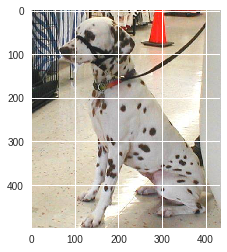

In [183]:
worst_paths=img_paths[np.argsort(-np.abs(np.nanmean(comparison,axis=1)-comp))]
for idx in range(10):
  val=np.nanmean(comparison[np.argsort(-np.abs(np.nanmean(comparison,axis=1)-comp))[idx],:])
  try:
    plt.imshow(plt.imread('dogscats_shuffled/train/dogs/'+worst_paths[idx]))
    print('Labelled as dog')
    print(val)
  except:
    plt.imshow(plt.imread('dogscats_shuffled/train/cats/'+worst_paths[idx]))
    print('Labelled as cat')
    print(val)


In [192]:
bad_paths=img_paths[np.abs(np.nanmean(comparison,axis=1)-comp)>0.5]
len(bad_paths)/23500

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.


0.08527659574468086

In [0]:
try:
  !rm -r /content/data/dogscats_shuffled_check/
except:
  None
!mkdir /content/data/dogscats_shuffled_check/
!cp -r /content/data/dogscats_shuffled/* /content/data/dogscats_shuffled_check/


In [202]:
data = ImageClassifierData.from_paths("dogscats_shuffled_check", tfms=tfms_from_model(arch, sz), bs=32)
learn = ConvLearner.pretrained(arch, data, precompute=True)
learn.fit(0.01, 3)


100%|██████████| 63/63 [00:09<00:00,  6.66it/s]


epoch      trn_loss   val_loss   accuracy   
    0      0.347791   0.19369    0.9495    
 42%|████▏     | 299/719 [00:06<00:09, 45.53it/s, loss=0.353]

    1      0.34575    0.152089   0.951     
 84%|████████▎ | 601/719 [00:13<00:02, 45.18it/s, loss=0.345]

    2      0.342812   0.153946   0.949     



[array([0.15395]), 0.949]

In [0]:
for x in bad_paths:
  try:
    os.remove('/content/data/dogscats_shuffled_check/train/dogs/'+x)
  except:
    try:
      os.remove('/content/data/dogscats_shuffled_check/train/cats/'+x)
    except:
      bad_paths

In [204]:
print(len(os.listdir('/content/data/dogscats_shuffled_check/train/dogs/')))
print(len(os.listdir('/content/data/dogscats_shuffled_check/train/cats/')))

10549
10447


In [205]:
data = ImageClassifierData.from_paths("dogscats_shuffled_check", tfms=tfms_from_model(arch, sz), bs=32)
learn = ConvLearner.pretrained(arch, data, precompute=True)
learn.fit(0.01, 3)


100%|██████████| 657/657 [01:39<00:00,  6.63it/s]


epoch      trn_loss   val_loss   accuracy   
    0      0.100369   0.129167   0.947     
 48%|████▊     | 315/657 [00:06<00:07, 45.80it/s, loss=0.0879]

    1      0.106633   0.129611   0.957     
 96%|█████████▋| 634/657 [00:13<00:00, 45.42it/s, loss=0.0751]

    2      0.075954   0.13641    0.9565    



[array([0.13641]), 0.9565]

In [0]:
!rm -r /content/data/dogscats
!unzip dogscats.zip

In [200]:
data = ImageClassifierData.from_paths("dogscats", tfms=tfms_from_model(arch, sz), bs=32)
learn = ConvLearner.pretrained(arch, data, precompute=True)
learn.fit(0.01, 3)

epoch      trn_loss   val_loss   accuracy   
    0      0.158083   0.121853   0.9485    
 41%|████      | 296/719 [00:06<00:09, 45.10it/s, loss=0.154]

    1      0.137867   0.111374   0.954     
 83%|████████▎ | 599/719 [00:13<00:02, 44.92it/s, loss=0.158]

    2      0.130771   0.11508    0.954     



[array([0.11508]), 0.954]

In [206]:
!mkdir /content/data/dogscats_cv/

sz=100
train_list=np.append(os.listdir('dogscats/train/dogs'),os.listdir('dogscats/train/cats'))
eval_train=np.empty((len(train_list), 10))
eval_train[:] = np.nan
eval_train=pd.DataFrame(data={'img_name':train_list})

for x in np.arange(0,10,1):
  print(x)
  !rm -r /content/data/dogscats_cv/*
  !cp -r /content/data/dogscats/* /content/data/dogscats_cv/
  !rm -r /content/data/dogscats_cv/valid/dogs/*
  !rm -r /content/data/dogscats_cv/valid/cats/*
  !shuf -zen5750 /content/data/dogscats_cv/train/dogs/* | xargs -0 mv -t /content/data/dogscats_cv/valid/dogs/
  !shuf -zen5750 /content/data/dogscats_cv/train/cats/* | xargs -0 mv -t /content/data/dogscats_cv/valid/cats/
  arch=resnet34
  data = ImageClassifierData.from_paths("dogscats_cv", tfms=tfms_from_model(arch, sz), bs=32)
  learn = ConvLearner.pretrained(arch, data, precompute=True)
  learn.fit(0.01, 3)
  log_preds = learn.predict()
  preds = np.argmax(log_preds, axis=1)  # from log probabilities to 0 or 1
  probs = np.exp(log_preds[:,1])
  res=pd.DataFrame(data={'img_name': [os.path.basename(y) for y in np.asarray(data.val_ds.fnames)], 'v'+str(x): probs})
  eval_train=pd.merge(eval_train, res,how='outer')

comp=np.zeros(23000)
comp[np.where(eval_train['img_name'].isin(pd.Series(np.asarray(os.listdir('dogscats/train/dogs'))))==True)]=1
comparison=np.array(eval_train.values[:,1:],dtype=np.float32)
img_paths=eval_train['img_name']
bad_paths=img_paths[np.abs(np.nanmean(comparison,axis=1)-comp)>0.5]

try:
  !rm -r /content/data/dogscats_check/
except:
  None
!mkdir /content/data/dogscats_check/
!cp -r /content/data/dogscats/* /content/data/dogscats_check/

data = ImageClassifierData.from_paths("dogscats_check", tfms=tfms_from_model(arch, sz), bs=32)
learn = ConvLearner.pretrained(arch, data, precompute=True)
learn.fit(0.01, 3)

for x in bad_paths:
  try:
    os.remove('/content/data/dogscats_check/train/dogs/'+x)
  except:
    try:
      os.remove('/content/data/dogscats_check/train/cats/'+x)
    except:
      bad_paths
data = ImageClassifierData.from_paths("dogscats_check", tfms=tfms_from_model(arch, sz), bs=32)
learn = ConvLearner.pretrained(arch, data, precompute=True)
learn.fit(0.01, 3)


0
rm: cannot remove '/content/data/dogscats_cv/*': No such file or directory
100%|██████████| 360/360 [00:54<00:00,  6.60it/s]


epoch      trn_loss   val_loss   accuracy   
    0      0.177252   0.112867   0.954174  
    1      0.156164   0.107344   0.956957  
 15%|█▌        | 55/360 [00:01<00:08, 37.94it/s, loss=0.15]

    2      0.156768   0.107121   0.958435  

1
100%|██████████| 360/360 [00:54<00:00,  6.63it/s]


epoch      trn_loss   val_loss   accuracy   
    0      0.165971   0.106252   0.956957  
    1      0.172083   0.117709   0.952435  
 15%|█▌        | 54/360 [00:01<00:08, 36.91it/s, loss=0.145]

    2      0.153385   0.104431   0.958435  

2
100%|██████████| 360/360 [00:54<00:00,  6.57it/s]


epoch      trn_loss   val_loss   accuracy   
    0      0.183309   0.109308   0.957391  
    1      0.160223   0.119854   0.952     
 14%|█▍        | 51/360 [00:01<00:08, 35.32it/s, loss=0.127]

    2      0.157129   0.103838   0.960174  

3
100%|██████████| 360/360 [00:54<00:00,  6.62it/s]


epoch      trn_loss   val_loss   accuracy   
    0      0.189571   0.115719   0.952696  
    1      0.158854   0.108436   0.95687   
 16%|█▌        | 57/360 [00:01<00:07, 42.22it/s, loss=0.143]

    2      0.163922   0.125279   0.950783  

4
100%|██████████| 360/360 [00:52<00:00,  6.80it/s]


epoch      trn_loss   val_loss   accuracy   
    0      0.211372   0.111084   0.956     
    1      0.168277   0.103653   0.958435  
 17%|█▋        | 61/360 [00:01<00:06, 43.51it/s, loss=0.174]

    2      0.145387   0.104152   0.959217  

5
100%|██████████| 360/360 [00:54<00:00,  6.57it/s]


epoch      trn_loss   val_loss   accuracy   
    0      0.176247   0.122293   0.949391  
    1      0.189883   0.109823   0.956087  
 16%|█▌        | 56/360 [00:01<00:08, 37.84it/s, loss=0.169]

    2      0.140565   0.10839    0.954261  

6
100%|██████████| 360/360 [00:54<00:00,  6.55it/s]


epoch      trn_loss   val_loss   accuracy   
    0      0.163386   0.112306   0.955304  
    1      0.170837   0.107218   0.958609  
 16%|█▌        | 57/360 [00:01<00:07, 38.88it/s, loss=0.147]

    2      0.132482   0.101137   0.959478  

7
100%|██████████| 360/360 [00:54<00:00,  6.57it/s]


epoch      trn_loss   val_loss   accuracy   
    0      0.199544   0.111833   0.955043  
    1      0.156309   0.111954   0.955304  
 15%|█▌        | 54/360 [00:01<00:08, 36.89it/s, loss=0.152]

    2      0.154244   0.101548   0.962087  

8
100%|██████████| 360/360 [00:54<00:00,  6.58it/s]


epoch      trn_loss   val_loss   accuracy   
    0      0.184518   0.112373   0.955913  
    1      0.165011   0.113162   0.956696  
 14%|█▍        | 51/360 [00:01<00:08, 34.48it/s, loss=0.15]

    2      0.148517   0.102992   0.960348  

9
100%|██████████| 360/360 [00:56<00:00,  6.42it/s]


epoch      trn_loss   val_loss   accuracy   
    0      0.18391    0.106057   0.957739  
    1      0.152291   0.107822   0.956435  
 16%|█▌        | 57/360 [00:01<00:07, 39.38it/s, loss=0.147]

    2      0.15625    0.10259    0.959391  



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in greater


epoch      trn_loss   val_loss   accuracy   
    0      0.1666     0.120408   0.9535    
 40%|████      | 288/719 [00:06<00:09, 43.71it/s, loss=0.174]

    1      0.121533   0.107909   0.9615    
 83%|████████▎ | 599/719 [00:13<00:02, 45.66it/s, loss=0.147]

    2      0.140248   0.107486   0.954     

100%|██████████| 693/693 [01:44<00:00,  6.61it/s]


epoch      trn_loss   val_loss   accuracy   
    0      0.098165   0.137624   0.9545    
 43%|████▎     | 296/693 [00:06<00:08, 44.37it/s, loss=0.0953]

    1      0.096379   0.131923   0.9545    
 87%|████████▋ | 606/693 [00:13<00:01, 45.64it/s, loss=0.0819]

    2      0.079537   0.140143   0.946     



[array([0.14014]), 0.946]

In [283]:
comp=np.zeros(23000)
comp[np.where(eval_train['img_name'].isin(pd.Series(np.asarray(os.listdir('dogscats/train/dogs'))))==True)]=1
comparison=np.array(eval_train.values[:,1:],dtype=np.float32)
img_paths=eval_train['img_name']
worst_paths=np.asarray(img_paths[np.argsort(-np.abs(np.nanmean(comparison,axis=1)-comp))])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: Mean of empty slice
  """


In [284]:
worst_paths[0]

'dog.10030.jpg'

In [281]:
plt.imshow(plt.imread('dogscats/train/dogs/'+worst_paths[0]))

FileNotFoundError: ignored

FileNotFoundError: ignored

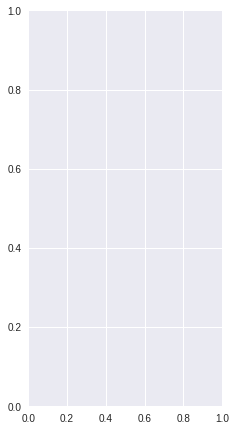

In [282]:
fig=plt.figure(figsize=(16, 16))
columns = 4
rows = 2
for i in range(0, columns*rows):
  fig.add_subplot(rows, columns, i+1)
  try:
      plt.imshow(plt.imread('dogscats/train/dogs/'+worst_paths[i]))
  except:
      plt.imshow(plt.imread('dogscats/train/cats/'+worst_paths[i]))
plt.show()

Labelled as dog
0.9999832


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: Mean of empty slice
  This is separate from the ipykernel package so we can avoid doing imports until


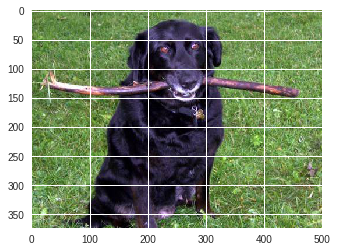

In [212]:
worst_paths=img_paths[np.argsort(-np.abs(np.nanmean(comparison,axis=1)-comp))]
for idx in range(1):
  val=np.nanmean(comparison[np.argsort(-np.abs(np.nanmean(comparison,axis=1)-comp))[idx],:])
  try:
    plt.imshow(plt.imread('dogscats_shuffled/train/dogs/'+worst_paths[idx]))
    print('Labelled as dog')
    print(val)
  except:
    plt.imshow(plt.imread('dogscats_shuffled/train/cats/'+worst_paths[idx]))
    print('Labelled as cat')
    print(val)

In [285]:
!wget https://github.com/danielcanueto/datasets/raw/master/manwoman.7z
!7z x manwoman.7z
print(os.listdir())
print(len(os.listdir('downloads/man')))
print(len(os.listdir('downloads/woman')))

!mkdir /content/data/manwoman/
!mkdir /content/data/manwoman/train
!mkdir /content/data/manwoman/train/man
!mkdir /content/data/manwoman/train/woman
!mkdir /content/data/manwoman/valid
!mkdir /content/data/manwoman/valid/man
!mkdir /content/data/manwoman/valid/woman

!cp -r /content/data/downloads/man/* /content/data/manwoman/train/man/
!cp -r /content/data/downloads/woman/* /content/data/manwoman/train/woman/

!shuf -zen49 /content/data/manwoman/train/man/* | xargs -0 mv -t /content/data/manwoman/valid/man/
!shuf -zen116 /content/data/manwoman/train/woman/* | xargs -0 mv -t /content/data/manwoman/valid/woman/

--2018-06-30 11:36:04--  https://github.com/danielcanueto/datasets/raw/master/manwoman.7z
Resolving github.com (github.com)... 192.30.253.113, 192.30.253.112
Connecting to github.com (github.com)|192.30.253.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/danielcanueto/datasets/master/manwoman.7z [following]
--2018-06-30 11:36:04--  https://raw.githubusercontent.com/danielcanueto/datasets/master/manwoman.7z
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17858309 (17M) [application/octet-stream]
Saving to: ‘manwoman.7z’

manwoman.7z         100%[===================>]  17.03M  31.6MB/s    in 0.5s    

2018-06-30 11:36:05 (31.6 MB/s) - ‘manwoman.7z’ saved [17858309/17858309]


7-Zip [64] 16.02 : Co

In [299]:

sz=100
train_list=np.append(os.listdir('manwoman/train/man'),os.listdir('manwoman/train/woman'))
eval_train=np.empty((len(train_list), 10))
eval_train[:] = np.nan
eval_train=pd.DataFrame(data={'img_name':train_list})

for x in np.arange(0,10,1):
  print(x)
  try:
    !mkdir /content/data/manwoman_cv/
  except:
    None
  !rm -r /content/data/manwoman_cv/*
  !cp -r /content/data/manwoman/* /content/data/manwoman_cv/
  !rm -r /content/data/manwoman_cv/valid/man/*
  !rm -r /content/data/manwoman_cv/valid/woman/*
  !shuf -zen75 /content/data/manwoman_cv/train/man/* | xargs -0 mv -t /content/data/manwoman_cv/valid/man/
  !shuf -zen75 /content/data/manwoman_cv/train/woman/* | xargs -0 mv -t /content/data/manwoman_cv/valid/woman/
  arch=resnet34
  data = ImageClassifierData.from_paths("manwoman_cv", tfms=tfms_from_model(arch, sz), bs=32)
  learn = ConvLearner.pretrained(arch, data, precompute=True)
  learn.fit(0.01, 3)
  log_preds = learn.predict()
  preds = np.argmax(log_preds, axis=1)  # from log probabilities to 0 or 1
  probs = np.exp(log_preds[:,1])
  res=pd.DataFrame(data={'img_name': [os.path.basename(y) for y in np.asarray(data.val_ds.fnames)], 'v'+str(x): probs})
  eval_train=pd.merge(eval_train, res,how='outer')




0
mkdir: cannot create directory ‘/content/data/manwoman_cv/’: File exists
100%|██████████| 5/5 [00:01<00:00,  3.19it/s]


epoch      trn_loss   val_loss   accuracy   
    0      0.748699   0.538376   0.72      
    1      0.645726   0.493621   0.74      
    2      0.549167   0.474794   0.76      

1
mkdir: cannot create directory ‘/content/data/manwoman_cv/’: File exists
100%|██████████| 5/5 [00:01<00:00,  3.18it/s]


epoch      trn_loss   val_loss   accuracy   
    0      0.852857   0.55489    0.766667  
    1      0.713611   0.434498   0.82      
    2      0.572086   0.40126    0.846667  

2
mkdir: cannot create directory ‘/content/data/manwoman_cv/’: File exists
100%|██████████| 5/5 [00:01<00:00,  3.26it/s]


epoch      trn_loss   val_loss   accuracy   
    0      0.862275   0.573802   0.68      
    1      0.634955   0.439274   0.78      
    2      0.556796   0.43722    0.786667  

3
mkdir: cannot create directory ‘/content/data/manwoman_cv/’: File exists
100%|██████████| 5/5 [00:01<00:00,  3.29it/s]


epoch      trn_loss   val_loss   accuracy   
    0      0.920435   0.764473   0.606667  
    1      0.707183   0.432466   0.813333  
    2      0.571044   0.40824    0.82      

4
mkdir: cannot create directory ‘/content/data/manwoman_cv/’: File exists
100%|██████████| 5/5 [00:01<00:00,  3.08it/s]


epoch      trn_loss   val_loss   accuracy   
    0      0.832456   0.546767   0.753333  
    1      0.646079   0.46337    0.766667  
    2      0.535009   0.443633   0.8       

5
mkdir: cannot create directory ‘/content/data/manwoman_cv/’: File exists
100%|██████████| 5/5 [00:01<00:00,  2.95it/s]


epoch      trn_loss   val_loss   accuracy   
    0      0.958751   0.490852   0.766667  
    1      0.687363   0.441265   0.8       
    2      0.561962   0.473217   0.76      

6
mkdir: cannot create directory ‘/content/data/manwoman_cv/’: File exists
100%|██████████| 5/5 [00:01<00:00,  3.20it/s]


epoch      trn_loss   val_loss   accuracy   
    0      0.783865   0.552583   0.726667  
    1      0.628442   0.409274   0.786667  
    2      0.538314   0.412307   0.8       

7
mkdir: cannot create directory ‘/content/data/manwoman_cv/’: File exists
100%|██████████| 5/5 [00:01<00:00,  3.24it/s]


epoch      trn_loss   val_loss   accuracy   
    0      0.894523   0.584556   0.726667  
    1      0.664074   0.546798   0.766667  
    2      0.519101   0.586081   0.78      

8
mkdir: cannot create directory ‘/content/data/manwoman_cv/’: File exists
100%|██████████| 5/5 [00:01<00:00,  3.26it/s]


epoch      trn_loss   val_loss   accuracy   
    0      0.942363   0.676338   0.6       
    1      0.654306   0.47757    0.793333  
    2      0.558405   0.449437   0.806667  

9
mkdir: cannot create directory ‘/content/data/manwoman_cv/’: File exists
100%|██████████| 5/5 [00:01<00:00,  3.20it/s]


epoch      trn_loss   val_loss   accuracy   
    0      0.813771   0.542157   0.706667  
    1      0.676275   0.433934   0.766667  
    2      0.552376   0.446692   0.766667  



In [301]:
comp=np.zeros(300)
comp[np.where(eval_train['img_name'].isin(pd.Series(np.asarray(os.listdir('manwoman/train/woman'))))==True)]=1
comparison=np.array(eval_train.values[:,1:],dtype=np.float32)
img_paths=eval_train['img_name']
bad_paths=img_paths[np.abs(np.nanmean(comparison,axis=1)-comp)>0.5]

try:
  !rm -r /content/data/manwoman_check/
except:
  None
!mkdir /content/data/manwoman_check/
!cp -r /content/data/manwoman/* /content/data/manwoman_check/

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: Mean of empty slice
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in greater
  """


rm: cannot remove '/content/data/manwoman_check/': No such file or directory


In [302]:
np.nanmean(np.array(eval_train.values[:,1:],dtype=np.float32),axis=1)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice
  """Entry point for launching an IPython kernel.


array([0.11139, 0.18691, 0.05806, 0.207  , 0.32574, 0.2126 , 0.07509, 0.18193, 0.4589 , 0.04312, 0.08702,
       0.18525, 0.65867, 0.8024 , 0.03299, 0.58673, 0.17363, 0.07178, 0.44781, 0.18938, 0.09624, 0.08438,
       0.01001, 0.53219, 0.1203 , 0.31512, 0.14382, 0.98482, 0.47749, 0.2356 , 0.00446, 0.48718, 0.23046,
       0.045  , 0.01546, 0.06879, 0.00838, 0.802  , 0.01383, 0.3861 , 0.40079, 0.04263, 0.93164, 0.12641,
       0.09931, 0.01296, 0.14729, 0.37948, 0.40192, 0.03078, 0.20161, 0.10392, 0.02371, 0.23263, 0.22464,
       0.41808, 0.0053 , 0.04402, 0.23603, 0.04541, 0.25323, 0.13977, 0.00653, 0.22853, 0.29898, 0.11109,
       0.69307, 0.49597, 0.20463, 0.00722, 0.04891, 0.18703, 0.28559, 0.07156, 0.00876, 0.01838, 0.02961,
       0.33453, 0.4875 , 0.04026, 0.05253, 0.68635, 0.11774, 0.29174, 0.33461, 0.21093, 0.14478, 0.0044 ,
       0.17158, 0.09481, 0.14125, 0.60205, 0.03724, 0.22844, 0.24354, 0.29829, 0.18324, 0.60338, 0.29823,
       0.0111 , 0.88718, 0.34058, 0.04379, 0.7

In [305]:
data = ImageClassifierData.from_paths("manwoman_check", tfms=tfms_from_model(arch, sz), bs=32)
learn = ConvLearner.pretrained(arch, data, precompute=True)
learn.fit(0.01, 10)


epoch      trn_loss   val_loss   accuracy   
    0      0.595733   0.552186   0.775758  
    1      0.435575   0.510503   0.830303  
    2      0.327549   0.525386   0.836364  
    3      0.250647   0.470379   0.842424  
    4      0.226773   0.571935   0.830303  
    5      0.189649   0.533277   0.836364  
    6      0.181659   0.576297   0.836364  
    7      0.152737   0.613469   0.830303  
    8      0.139989   0.565257   0.836364  
    9      0.122462   0.602959   0.824242  



[array([0.60296]), 0.8242424242424242]

In [306]:

for x in bad_paths:
  try:
    os.remove('/content/data/manwoman_check/train/man/'+x)
  except:
    try:
      os.remove('/content/data/manwoman_check/train/woman/'+x)
    except:
      bad_paths
data = ImageClassifierData.from_paths("manwoman_check", tfms=tfms_from_model(arch, sz), bs=32)
learn = ConvLearner.pretrained(arch, data, precompute=True)
learn.fit(0.01, 10)

epoch      trn_loss   val_loss   accuracy   
    0      0.758899   0.428225   0.824242  
    1      0.497157   0.438377   0.836364  
    2      0.359537   0.441287   0.854545  
    3      0.276945   0.47591    0.848485  
    4      0.236982   0.476258   0.842424  
    5      0.197684   0.555814   0.842424  
    6      0.165133   0.5911     0.824242  
    7      0.147165   0.578941   0.836364  
    8      0.129534   0.532196   0.854545  
    9      0.114465   0.528339   0.836364  



[array([0.52834]), 0.8363636367248767]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: Mean of empty slice
  This is separate from the ipykernel package so we can avoid doing imports until


0.9848219
0.06761773
0.9316368


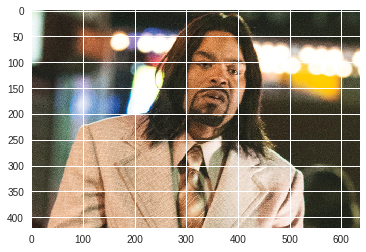

In [310]:
worst_paths=np.asarray(img_paths[np.argsort(-np.abs(np.nanmean(comparison,axis=1)-comp))])
for idx in range(3):
  val=np.nanmean(comparison[np.argsort(-np.abs(np.nanmean(comparison,axis=1)-comp))[idx],:])
  try:
    plt.imshow(plt.imread('manwoman/train/man/'+worst_paths[idx]))
    print(val)
  except:
    plt.imshow(plt.imread('manwoman/train/woman/'+worst_paths[idx]))
    print(val)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice
  """Entry point for launching an IPython kernel.


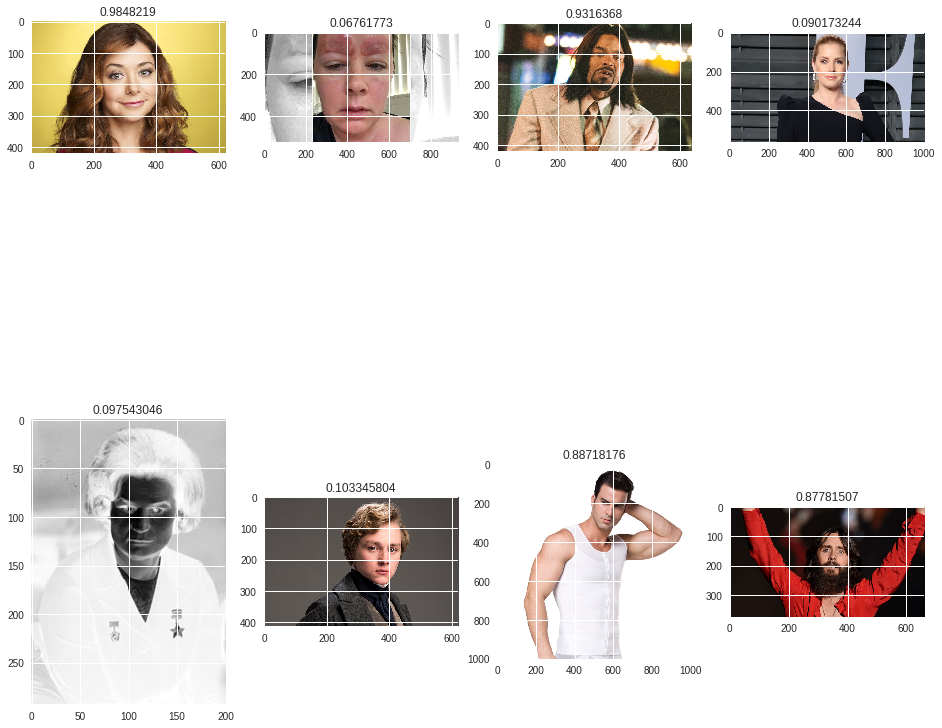

In [317]:
val=np.nanmean(comparison[np.argsort(-np.abs(np.nanmean(comparison,axis=1)-comp))[0:8],:],axis=1)

fig=plt.figure(figsize=(16, 16))
columns = 4
rows = 2
for i in range(0, columns*rows):
  fig.add_subplot(rows, columns, i+1).title.set_text(str(val[i]))
  try:
      plt.imshow(plt.imread('manwoman/train/man/'+worst_paths[i]))
  except:
      plt.imshow(plt.imread('manwoman/train/woman/'+worst_paths[i]))
plt.show()

In [316]:
val=np.nanmean(comparison[np.argsort(-np.abs(np.nanmean(comparison,axis=1)-comp))[0:8],:])
val

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice
  """Entry point for launching an IPython kernel.
